              Total Return (%) Avg Annual Return (%) Standard Deviation (%)  \
Konkurrent 1            49.66%                 3.98%                  6.37%   
Konkurrent 2            88.41%                 6.32%                 13.94%   
Artha Safe              32.55%                 2.76%                  2.69%   
Artha Optimum           82.68%                 6.00%                  5.81%   
Artha Max              135.08%                 8.62%                  8.62%   

              Sharpe Ratio  
Konkurrent 1          0.64  
Konkurrent 2          0.46  
Artha Safe            1.07  
Artha Optimum         1.05  
Artha Max             1.01  
Historic Max Drawdowns (%):
Konkurrent 1: -13.35%
Konkurrent 2: -26.04%
Artha Safe: -7.37%
Artha Optimum: -13.62%
Artha Max: -20.16%


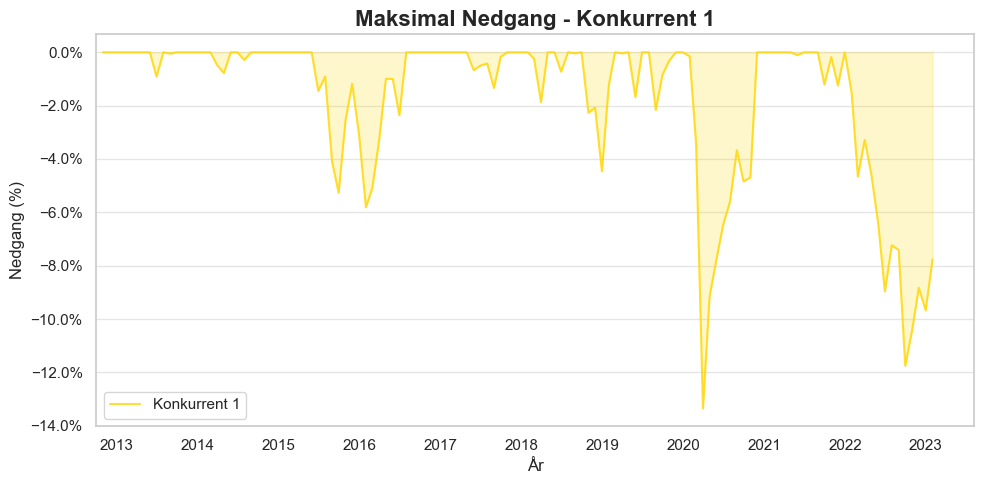

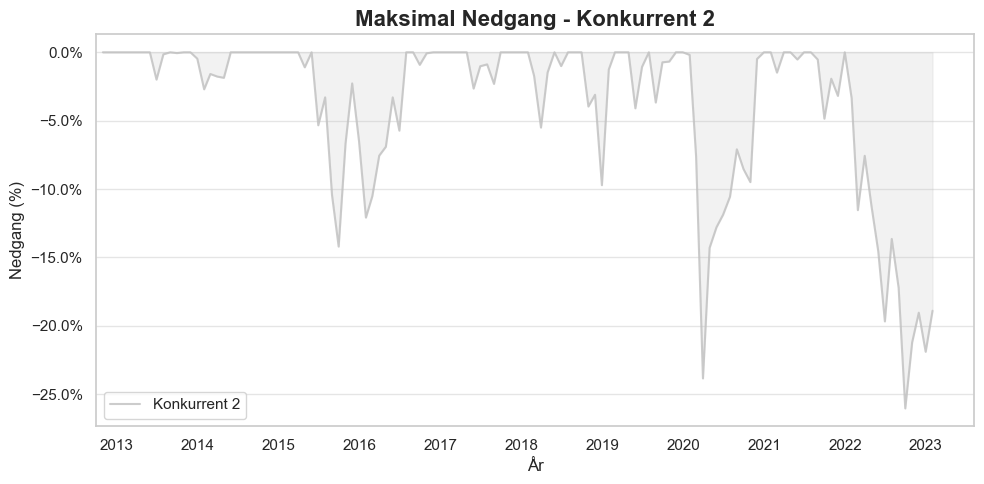

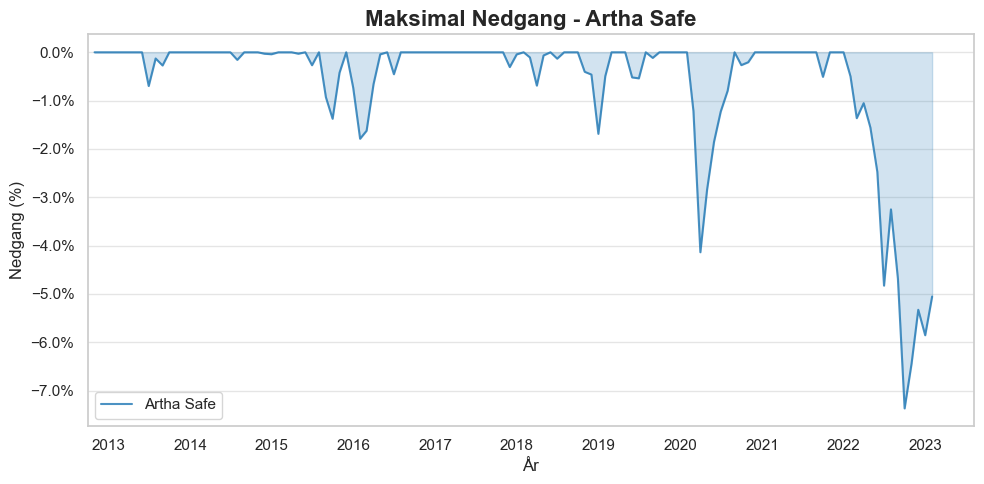

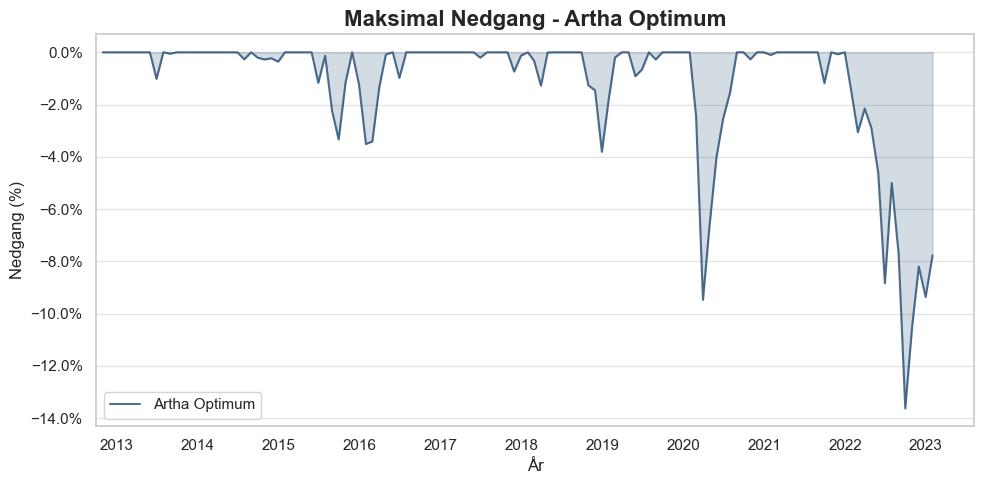

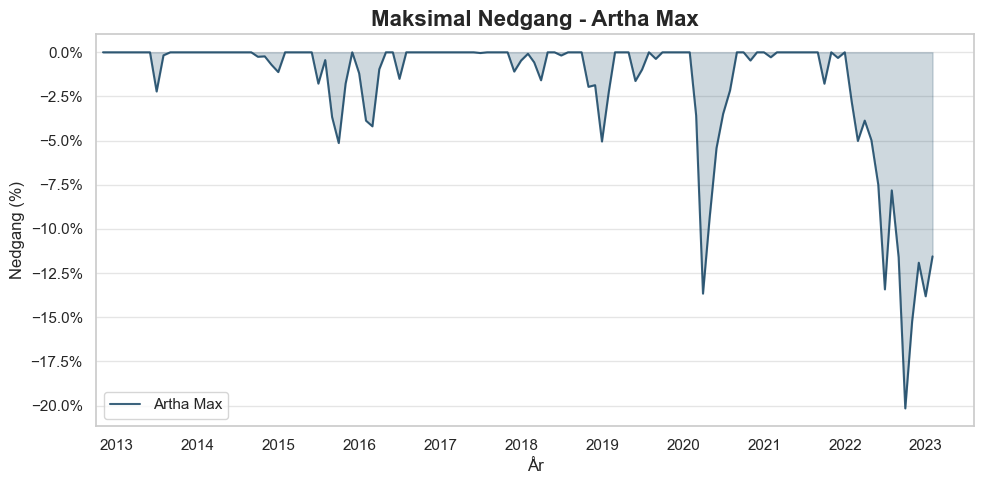

In [33]:
# Importer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
from scipy.stats import norm
warnings.filterwarnings('ignore')

# Load data
funds = pd.read_excel('/Users/due/Desktop/ArthaScope Datatest.xlsm', header=1).drop("Unnamed: 6", axis=1)
funds['Dato'] = pd.to_datetime(funds['Dato'], errors='coerce')
funds.set_index('Dato', inplace=True)
funds = funds[funds.index >= pd.to_datetime('2012-09-30')]
funds = funds.resample('M').last()

# Definition af porteføljer og risk-free rate
fund_names = ["Konkurrent 1", "Konkurrent 2", "Artha Safe", "Artha Optimum", "Artha Max"]
monthly_cibor1m = -0.0012  # Risk-free rate

# Beregning af performance
results = {}
for fund in fund_names:
    data = funds[[fund]].dropna()
    total_return = (data.iloc[-1, 0] - data.iloc[0, 0]) / data.iloc[0, 0]
    years = (data.index[-1] - data.index[0]).days / 365.25
    avg_annual_return = (data.iloc[-1, 0] / data.iloc[0, 0]) ** (1 / years) - 1
    std_dev = data.pct_change().dropna().std()[0] * np.sqrt(12)
    sharpe_ratio = (avg_annual_return - monthly_cibor1m) / std_dev

    results[fund] = {
        'Total Return (%)': f"{total_return * 100:.2f}%",
        'Avg Annual Return (%)': f"{avg_annual_return * 100:.2f}%",
        'Standard Deviation (%)': f"{std_dev * 100:.2f}%",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}"
    }

# Konverter data til DataFrame
result_df = pd.DataFrame(results).T
print(result_df)

# Beregn historisk Max Drawdown
def max_drawdown(series):
    cumulative = (1 + series.pct_change()).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1
    return drawdown * 100

drawdown_series = {fund: max_drawdown(funds[fund]) for fund in fund_names}
print("Historic Max Drawdowns (%):")
historic_max_drawdowns = {fund: series.min() for fund, series in drawdown_series.items()}
for fund, dd in historic_max_drawdowns.items():
    print(f"{fund}: {dd:.2f}%")

# Plot Maximum Drawdown
sns.set_theme(style="whitegrid")
custom_palette = {
    'Konkurrent 1': 'gold',
    'Konkurrent 2': 'silver',
    'Artha Safe': '#1f77b4',
    'Artha Optimum': '#274e75',
    'Artha Max': '#0b3c5d'
}

for name, series in drawdown_series.items():
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=series.index, y=series, label=name, color=custom_palette[name], linewidth=1.5, alpha=0.8)
    plt.fill_between(series.index, series, y2=0, color=custom_palette[name], alpha=0.2)
    plt.title(f"Maksimal Nedgang - {name}", fontsize=16, weight="bold")
    plt.xlabel("År", fontsize=12)
    plt.ylabel("Nedgang (%)", fontsize=12)
    plt.xlim(left=series.index.min())
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    plt.gca().xaxis.grid(False)
    plt.tight_layout()
    plt.show()

In [34]:
# Beregning af Risk Metrics
def semideviation(r):
    return r[r < 0].std(ddof=0)

def var_historic(r, level=5):
    return -np.percentile(r, level)

def cvar_historic(r, level=5):
    is_beyond = r <= -var_historic(r, level=level)
    return -r[is_beyond].mean()

def var_gaussian(r, level=5, modified=False):
    z = norm.ppf(level/100)
    return -(r.mean() + z*r.std(ddof=0))

risk_metrics = {}
for fund in fund_names:
    returns = funds[fund].pct_change().dropna()
    risk_metrics[fund] = {
        'Semideviation': semideviation(returns),
        'VaR (5%)': var_historic(returns, level=5),
        'VaR (1%)': var_historic(returns, level=1),
        'CVaR (5%)': cvar_historic(returns, level=5),
        'CVaR (1%)': cvar_historic(returns, level=1),
        'Gaussian VaR (5%)': var_gaussian(returns, level=5),
        'Gaussian VaR (1%)': var_gaussian(returns, level=1)
    }

risk_df = pd.DataFrame(risk_metrics).T
print("Additional Risk Metrics:")
print(risk_df)

# Plot Maximum Drawdown
sns.set_theme(style="whitegrid")
custom_palette = {
    'Konkurrent 1': 'gold',
    'Konkurrent 2': 'silver',
    'Artha Safe': '#1f77b4',
    'Artha Optimum': '#274e75',
    'Artha Max': '#0b3c5d'
}

Additional Risk Metrics:
               Semideviation  VaR (5%)  VaR (1%)  CVaR (5%)  CVaR (1%)  \
Konkurrent 1        0.018074  0.026747  0.043687   0.043104   0.074759   
Konkurrent 2        0.033333  0.059994  0.101536   0.091927   0.141147   
Artha Safe          0.007373  0.010475  0.027245   0.018836   0.028874   
Artha Optimum       0.016312  0.022674  0.059486   0.040020   0.067980   
Artha Max           0.023804  0.031748  0.089230   0.058173   0.100687   

               Gaussian VaR (5%)  Gaussian VaR (1%)  
Konkurrent 1            0.026684           0.039160  
Konkurrent 2            0.059990           0.087306  
Artha Safe              0.010425           0.015699  
Artha Optimum           0.022448           0.033826  
Artha Max               0.033524           0.050408  
